# Fitting

In [2]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import Operator
from tqdm.notebook import tqdm

from kraus_channels import KrausMap, isomery_to_kraus
from loss_functions import ProbabilityMSE, ProbabilityRValue
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import channel_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, CorruptionMatrix
from utils import saver
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio
from quantum_circuits import integrable_circuit


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def load_data(filename, n, seed, L):
    with open(filename, 'rb') as f:
        data = pkl.load(f)


    data = marginalize_counts(data, 0)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(seed)
    
    circuit_target = integrable_circuit(n+1, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 3000,
             verbose = False):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    #povm = POVM(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = verbose,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 3000,
              verbose=False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=verbose
                )
    
    return model

In [22]:
path = '../data/chaos_exp_reorder/5q/integrable_L=5/'
n = 4
d = 2**n
L = 5

spam_list = []
model_list = []
unitary_list = []

for i in tqdm(range(10)):
    seed = 42 + i
    inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data(path + f'seed_{seed}.pkl', n, seed, L)
    
    unitary_list.append(unitary)

    tf.random.set_seed(seed)
    spam_model = fit_spam(inputs_spam, targets_spam, verbose=False)
    spam_list.append(spam_model) 

    tf.random.set_seed(seed)
    model = fit_model(inputs_map, 
                     targets_map, 
                     spam_model,
                     num_iter = 3000, 
                     verbose=False)
    model_list.append(model)



model_saver(spam_list, f'models/integrable_spam_{n}_L=5_reorder.model')
model_saver(model_list, f'models/integrable_model_{n}_L=5_reorder.model')
saver(unitary_list, f'models/integrable_unitary_{n}_L=5_reorder.model')

  0%|          | 0/10 [00:00<?, ?it/s]

[0.9978314503218609]
[0.9981250451373122]
[0.998168871973158]
[0.9984630607553093]
[0.9978992611315077]
[0.997666890065046]
[0.9979967688391574]
[0.9979747870063246]
[0.9979836088686286]
[0.9981207032779957]


## Check numerical and model

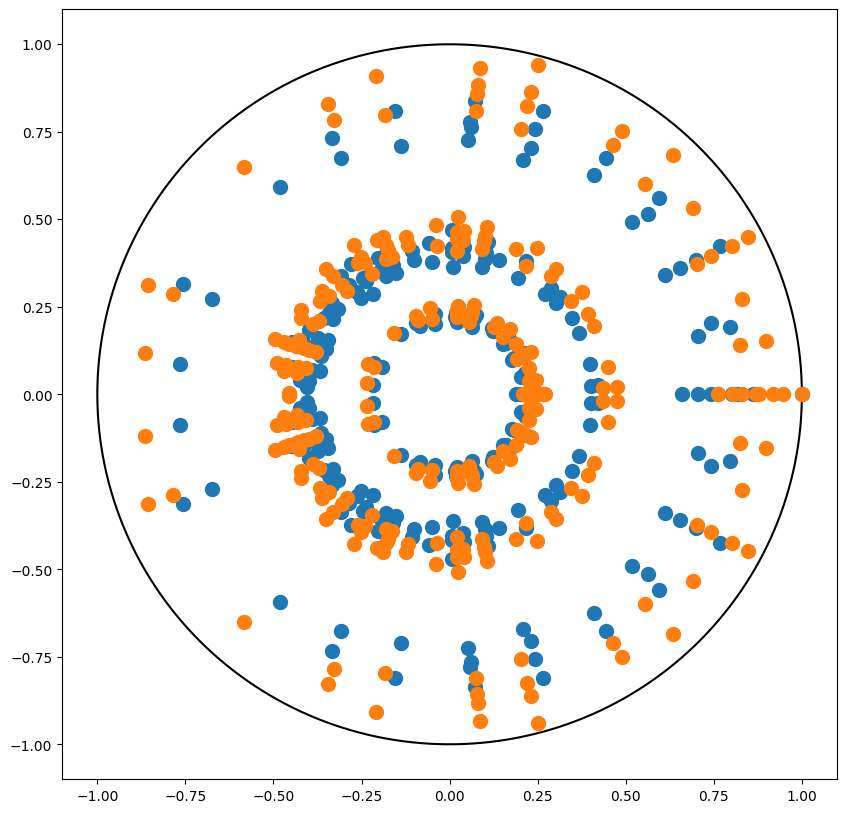

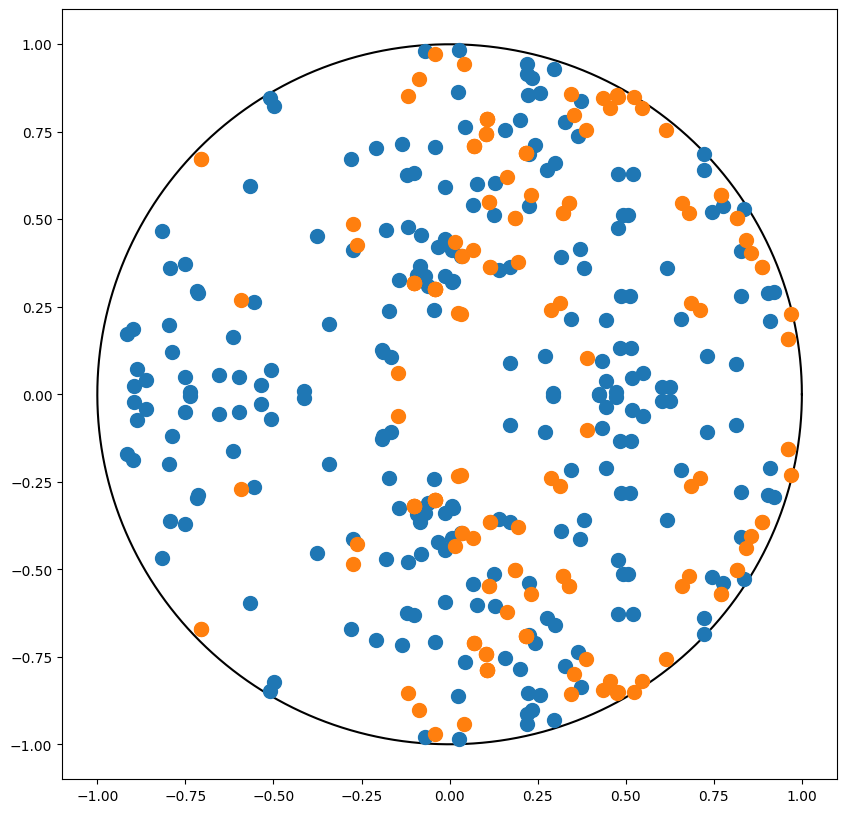

Fidelity: tf.Tensor(0.0036992094482606705, shape=(), dtype=float64)


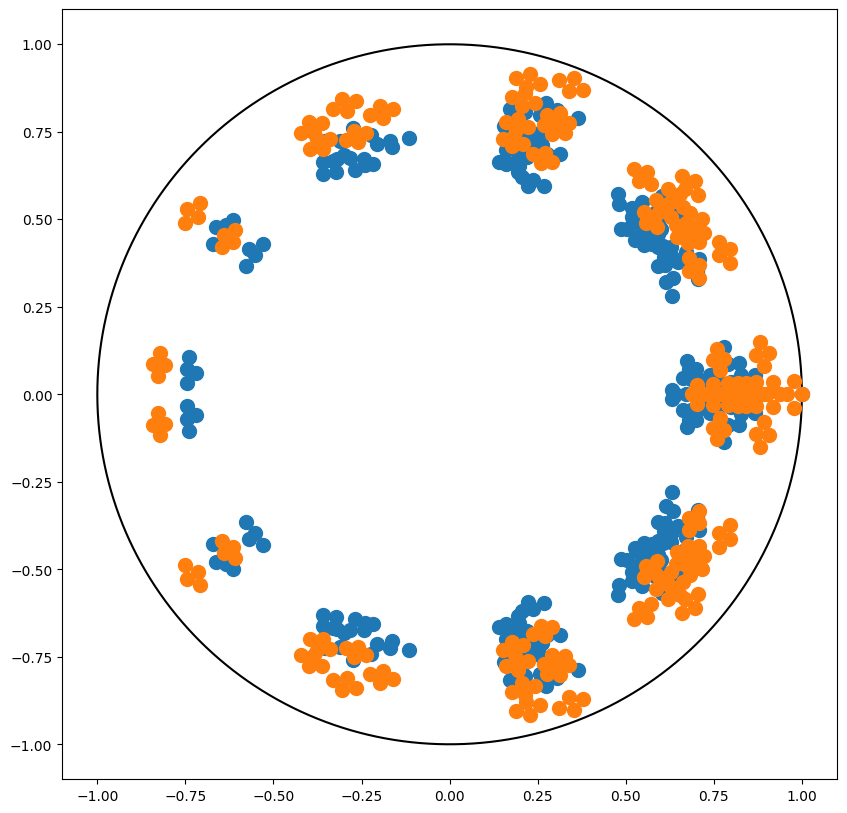

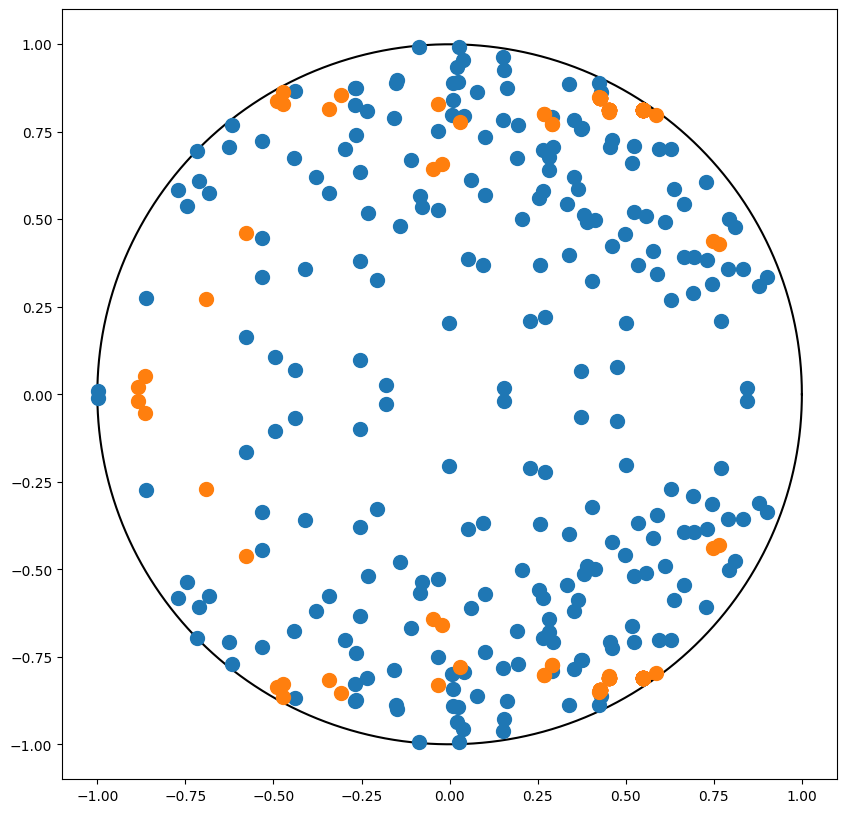

Fidelity: tf.Tensor(0.27055043658152506, shape=(), dtype=float64)


In [21]:
for i, (model, unitary) in enumerate(zip(model_list, unitary_list)):
    channel = model.channel

    np.random.seed(42+i)
    circuit_target = integrable_circuit(n+1, L)
    unitary = Operator(circuit_target).data
    channel_target = isomery_to_kraus(unitary, rank=2)

    spectrum = channel_spectrum(channel)
    spectrum_target = channel_spectrum(channel_target)
    spectrum.plot_circle()
    spectrum.plot()
    spectrum_target.plot()
    plt.show()

    csr = complex_spacing_ratio(spectrum)
    csr_target = complex_spacing_ratio(spectrum_target)

    csr.plot_circle()
    csr.plot()
    csr_target.plot()
    plt.show()


    print('Fidelity:', channel_fidelity(channel, channel_target))